<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Fake-News-Detection-ISOT/fake_news_detection_isot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libs

In [1]:
!pip install -q pandas numpy matplotlib seaborn kaggle tokenizers tensorflow scikit-learn

# Import Libs

In [4]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from google.colab import userdata

# Download Dataset

In [5]:
# Download dataset
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

#!/bin/bash
!kaggle datasets download clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.68GB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


# Load & Prepare Dataset

In [6]:
# Loading the datasets
true_ds = pd.read_csv("True.csv")
fake_ds = pd.read_csv("Fake.csv")

# Add lables
true_ds['label'] = 1
fake_ds['label'] = 0

# Concat dataframes and shuffle data
df = pd.concat([true_ds, fake_ds]).sample(frac=1, random_state=42).reset_index(drop=True)
df = df[['title', 'label']]

print(f"Dataset size: {len(df)}")
print(df['label'].value_counts())

Dataset size: 44898
label
0    23481
1    21417
Name: count, dtype: int64


# Split Dataset

In [7]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    df['title'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# BPE

In [8]:
# Tokenization (Byte-Pair Encoding)

def train_bpe_tokenizer(texts, vocab_size=12000):
    tokenizer = Tokenizer(BPE(unk_token="<unk>"))
    tokenizer.pre_tokenizer = ByteLevel(add_prefix_space=True)
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=2,
        special_tokens=["<pad>", "<unk>"]
    )
    # Save training text
    with open("train_texts.txt", "w", encoding="utf-8") as f:
        for line in texts:
            f.write(str(line) + "\n")
    tokenizer.train(files=["train_texts.txt"], trainer=trainer)
    return tokenizer

tokenizer = train_bpe_tokenizer(X_train, vocab_size=12000)
pad_token_id = tokenizer.token_to_id("<pad>")
vocab_size = tokenizer.get_vocab_size()
max_len = 40

# Encoding

In [9]:
def encode_texts(tokenizer, texts, max_len):
    encoded = tokenizer.encode_batch([str(t) for t in texts])
    sequences = []
    for e in encoded:
        ids = e.ids[:max_len]
        padded = ids + [pad_token_id] * (max_len - len(ids))
        sequences.append(padded)
    return np.array(sequences)

X_train_enc = encode_texts(tokenizer, X_train, max_len)
X_test_enc = encode_texts(tokenizer, X_test, max_len)

print(f"Encoded train shape: {X_train_enc.shape}")
print(f"Encoded test shape: {X_test_enc.shape}")

Encoded train shape: (35918, 40)
Encoded test shape: (8980, 40)


# Model Definition

In [10]:
# Model Architecture

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training

In [11]:
# Training

history = model.fit(
    X_train_enc, y_train,
    validation_data=(X_test_enc, y_test),
    epochs=8,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 284s 474ms/step - accuracy: 0.8623 - loss: 0.2846 - val_accuracy: 0.9978 - val_loss: 0.0064
Epoch 2/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 310s 462ms/step - accuracy: 0.9986 - loss: 0.0056 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 3/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 260s 462ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 4/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 260s 458ms/step - accuracy: 0.9998 - loss: 8.1438e-04 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 5/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 259s 461ms/step - accuracy: 0.9999 - loss: 4.4371e-04 - val_accuracy: 0.9984 - val_loss: 0.0058
Epoch 6/8
562/562 ━━━━━━━━━━━━━━━━━━━━ 265s 465ms/step - accuracy: 0.9997 - loss: 8.0050e-04 - val_accuracy: 0.9987 - val_loss: 0.0048


# Evaluation

281/281 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.9995 - loss: 0.0018

✅ Test Accuracy: 0.9993
281/281 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step

               precision    recall  f1-score   support

           0     0.9991    0.9996    0.9994      4696
           1     0.9995    0.9991    0.9993      4284

    accuracy                         0.9993      8980
   macro avg     0.9993    0.9993    0.9993      8980
weighted avg     0.9993    0.9993    0.9993      8980



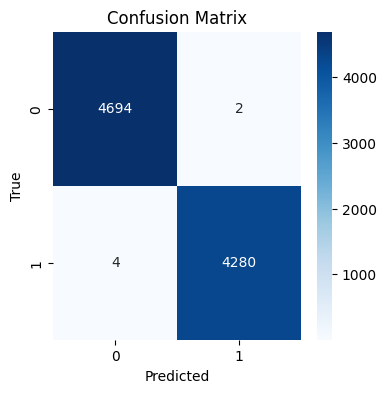

In [12]:
# Evaluation

loss, acc = model.evaluate(X_test_enc, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Classification report
y_pred = (model.predict(X_test_enc) > 0.5).astype(int)
print("\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
plt.figure(figsize=(4, 4))
sns = __import__("seaborn")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Training Curves

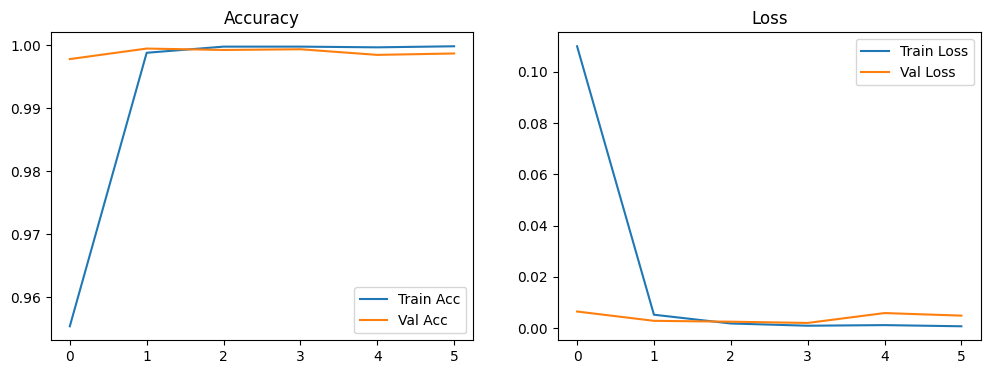

In [13]:
# Training Curves

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()
plt.show()